In [1]:
import numpy as np
import tensorflow as tf
import os
import time
from datetime import timedelta
from matplotlib import pyplot as plt
from skimage import data
from skimage import transform
from skimage.filters import sobel
from skimage.color import rgb2gray
from pandas import read_csv

In [2]:
### Read data from file
# set data path
train_path = "data/Trainset/"
test_path = "data/Testset/Online-Test/Images"
test_csv_path = "data/Testset/Online-Test/GT-online_test.csv"

## first read training data
# get all folders
directories = [d for d in os.listdir(train_path)
              if os.path.isdir(os.path.join(train_path, d))]

train_images = []
labels_tr = []
# loop over all folders and get the image names
for d in directories:
    current_dir = os.path.join(train_path, d)
    file_names = [os.path.join(current_dir, f)
                   for f in os.listdir(current_dir)
                   if f.endswith(".ppm")]
    for f in file_names:
        train_images.append(data.imread(f))
        labels_tr.append(int(d))

In [3]:
# Load test images
file_names = [os.path.join(test_path, f)
            for f in os.listdir(test_path)
            if f.endswith(".ppm")]

# sort file names to be equal of labels in CSV files
file_names.sort()

test_images = []
for f in file_names:
    test_images.append(data.imread(f))



In [4]:
# Load test set labels from csv file
test_labels_csv = read_csv(test_csv_path,sep=';')
test_labels = test_labels_csv.ClassId[:].values

In [5]:
## resize all images to 32 by 32 pixel
# Image size:
image_size = 32
# number of channel
num_channel = 2  # grayscale + sobel
# Resizing
images_tr = [transform.resize(i,(32,32), mode='constant') for i in train_images]
images_ts = [transform.resize(i,(32,32), mode='constant') for i in test_images]
# convert to grayscale
images_tr = [rgb2gray(i) for i in images_tr]
images_ts = [rgb2gray(i) for i in images_ts]

# get sobel filters
sobel_tr = [sobel(i) for i in images_tr]
sobel_ts = [sobel(i) for i in images_ts]

# Concatenate sobel and grayscale as a two channel image
images_tr = np.concatenate([images_tr, sobel_tr],-1)
images_ts = np.concatenate([images_ts, sobel_ts],-1)

In [6]:
# divide test data into two dataset and validation set
# to be sure we have to work with right data length
#assert len(test_images)==len(test_labels)

# as we can see, the length of labels and images are not equal!!
# we will use images length which are smaller than labels
m = len(images_ts)
# create a shuffle list
per = np.arange(m)
np.random.shuffle(per)

# remove the last labels
test_labels = test_labels[0:m]

# convert images list to np.array
test_images_np = np.array(images_ts)

# shuffle testset before dividing
test_images_shuffled = test_images_np[per]
test_labels_shuffled = test_labels[per]

# half of the length
half = int(m/2)

# first half = testset
images_ts = test_images_shuffled[0:half]
labels_ts = test_labels_shuffled[0:half]

# second half = devset
images_dv = test_images_shuffled[half:m]
labels_dv = test_labels_shuffled[half:m]

In [7]:
# Mini batch generator
def mini_batch_generator(x, y, mini_batch_size):
    '''
    Get data and shuffle the indices then divide data into mini_batch_size 
    '''
    assert len(x)==len(y)
    
    # length of input data
    m = len(x)
    
    # create a shuffled list of indices
    idx = np.random.permutation(m)
    
    # shuffle data
    x_shuffle = x[idx]
    y_shuffle = y[idx]
    
    # calculate number of mini batches
    num_mini_batches = int(m/mini_batch_size)
    
    # create a list to hold mini batches
    mini_batches = []
    
    for i in range(num_mini_batches):
        # take i-th mini batch from shuffled data
        x_batch = x_shuffle[i*mini_batch_size:i*mini_batch_size + mini_batch_size]
        y_batch = y_shuffle[i*mini_batch_size:i*mini_batch_size + mini_batch_size]
        batch = (x_batch, y_batch)
        # append batch to list of mini batches
        mini_batches.append(batch)
        
    return mini_batches

In [8]:
def one_hot_encoder(y, num_classes=None):
    '''
    get a list of numbers and convert it to one-hot vectors based number of classes
    '''
    # if num_classes is not provided, we can find it based on unique numbers in the list
    if num_classes is None:
        num_classes = len(set(y))
    # this is trick! thank to the stackoverflow!
    return np.eye(num_classes)[y]

In [9]:
# get the length of number of classes
num_classes = len(set(labels_tr))
# Convert labels to one-hot vectors
train_one_hot_labels = one_hot_encoder(labels_tr, num_classes)
devset_one_hot_labels = one_hot_encoder(labels_dv, num_classes)
testset_one_hot_labels = one_hot_encoder(labels_ts, num_classes)

In [10]:
## First set hyper parameters
kernel_size = [3, 3, 3, 3]
filter_depths = [16 , 32, 32, 64]
max_pooling = [False, True, False, True]
mini_batch_size = 64
lr = 0.001
lr_decay = 0.95
fc_hidden = 512
fc_layers = 2
dropout = 0.5
num_epochs = 20

In [11]:
## initial inputs placeholder
# input images
X = tf.placeholder(dtype=tf.float32, shape=[None, image_size, image_size, num_channel], name='X')
# input labels
Y_true = tf.placeholder(dtype=tf.float32, shape=[None, num_classes], name='Y')

Y_true_cls = tf.argmax(Y_true, 1)

keep_prob = tf.Variable(initial_value=0.5, dtype=tf.float32, name='keep_prob', trainable=False)

learning_rate = tf.Variable(initial_value=0.001, dtype=tf.float32, name="learning_rate", trainable=False)

In [12]:
## define CNN layers
cnn_input = X
assert len(kernel_size)==len(filter_depths)==len(max_pooling)

for i in range(len(kernel_size)):
    cnn_input = tf.layers.conv2d(cnn_input, 
                                 filters=filter_depths[i], 
                                 kernel_size=kernel_size[i], 
                                 padding='same', 
                                 activation=tf.nn.relu)
    # max pooling only on layers which are True
    if max_pooling[i]:
        cnn_input = tf.layers.max_pooling2d(cnn_input, pool_size=2, strides=2)
    
    # print what happen to layers! :)
    print("layer {} conv2d: {}".format(i, cnn_input.get_shape()))

layer 0 conv2d: (?, 32, 32, 16)
layer 1 conv2d: (?, 16, 16, 32)
layer 2 conv2d: (?, 16, 16, 32)
layer 3 conv2d: (?, 8, 8, 64)


In [13]:
## Define fully connected layer
fc_input = tf.contrib.layers.flatten(cnn_input)
for i in range(fc_layers):
    fc_input = tf.contrib.layers.fully_connected(fc_input, fc_hidden)
    fc_input = tf.nn.dropout(fc_input, keep_prob=keep_prob)
    fc_hidden = int(fc_hidden/2)


In [14]:
## Compute logits and cost
logits = tf.contrib.layers.fully_connected(fc_input, num_classes, activation_fn=None)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y_true)
cost = tf.reduce_mean(cross_entropy)



In [15]:
## Optimize cost with adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [16]:
## predict labels
y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, 1)

In [17]:
## Calculate accuracy
correct_prediction = tf.equal(y_pred_cls, Y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [18]:
# convert train_images to np.array
images_tr_np = np.array(images_tr)
# reshape images to [mini_batch_size, image_size, image_size, num_channel]
images_tr_np = np.reshape(images_tr_np, [-1, image_size, image_size, num_channel])

images_dv_np = np.array(images_dv)
# reshape images to [mini_batch_size, image_size, image_size, num_channel]
images_dv_np = np.reshape(images_dv_np, [-1, image_size, image_size, num_channel])


# Save best model
save_dir = "checkpoints/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

save_path = os.path.join(save_dir, 'GTSC')
# initial tensorflow global variables
init = tf.global_variables_initializer()

# create a saver object
saver = tf.train.Saver()
    
with tf.Session() as sess:
    # run global initializer
    sess.run(init)
    
    # create a list to store train cost and validation cost for further plot
    epoch_costs = []
    validation_costs = []
    
    # store best accuracy over the batches
    best_acc = 0.

    # start computation
    tic = time.time()
    
    # Loop over number of epochs
    for e in range(num_epochs):

        train_losses = 0.
        # generate mini bachtes in each epoch to generate each time differently
        mini_batches = mini_batch_generator(images_tr_np, train_one_hot_labels, mini_batch_size=mini_batch_size)

        # Loop over train mini_batches
        for b in mini_batches:
            # get the X,Y batches
            x_batch, y_batch = b
            loss, _ = sess.run([cost, optimizer], feed_dict={X:x_batch,
                                                           Y_true: y_batch,
                                                            learning_rate:lr,
                                                           keep_prob:dropout})
            train_losses += loss
            
        # add epoch_loss to train cost
        epoch_costs.append(train_losses)
        
        # decay learning rate with lr_decay
        lr = lr * lr_decay
        
        ## evaluate over devset
        # Generate devset mini batches
        devset_mini_batches = mini_batch_generator(images_dv_np, 
                                                   devset_one_hot_labels, 
                                                   mini_batch_size=mini_batch_size)
        
        # check accuracy over trained model
        dev_accs = []
        dev_losses = 0.
        
        # Loop over devset mini batches
        for b in devset_mini_batches:
            
            x_batch, y_batch = b
            
            loss, acc = sess.run([cost, accuracy], feed_dict={X:x_batch,
                                                           Y_true: y_batch,
                                                           keep_prob:1.0})
            dev_accs.append(acc)
            dev_losses += loss
        
        # Print a report of current epoch:
        print("Epoch:{0:>3} train cost: {1:>6.2f} dev cost:{2:>6.2f} dev accuracy:{3:>4.2%}".format(e+1,
                                                                                                   train_losses,
                                                                                                   dev_losses,
                                                                                                   np.mean(dev_accs)))
        
        # save model if achieved better accuracy
        if best_acc < np.mean(dev_accs):
            saver.save(sess, save_path=save_path)
        
    # Finish computation
    toc = time.time()
    print("Total time of training: " + str(timedelta(seconds=int(toc-tic))))

Epoch:  1 train cost: 1017.53 dev cost: 79.26 dev accuracy:77.09%
Epoch:  2 train cost: 238.54 dev cost: 26.72 dev accuracy:92.24%
Epoch:  3 train cost: 101.51 dev cost: 20.64 dev accuracy:94.23%
Epoch:  4 train cost:  59.84 dev cost: 19.47 dev accuracy:94.61%
Epoch:  5 train cost:  38.65 dev cost: 17.84 dev accuracy:95.68%
Epoch:  6 train cost:  31.13 dev cost: 16.35 dev accuracy:95.93%
Epoch:  7 train cost:  24.96 dev cost: 16.54 dev accuracy:95.81%
Epoch:  8 train cost:  20.57 dev cost: 15.68 dev accuracy:96.32%
Epoch:  9 train cost:  16.23 dev cost: 20.03 dev accuracy:96.09%
Epoch: 10 train cost:  15.35 dev cost: 13.82 dev accuracy:96.64%
Epoch: 11 train cost:  13.62 dev cost: 15.06 dev accuracy:96.64%
Epoch: 12 train cost:  10.15 dev cost: 16.66 dev accuracy:96.29%
Epoch: 13 train cost:   9.62 dev cost: 17.00 dev accuracy:96.40%
Epoch: 14 train cost:   8.28 dev cost: 16.99 dev accuracy:96.38%
Epoch: 15 train cost:   9.52 dev cost: 16.63 dev accuracy:96.72%
Epoch: 16 train cost:   

In [20]:
# Convert testset to np.array
images_ts_np = np.array(images_ts)
# reshape images to [mini_batch_size, image_size, image_size, num_channel]
images_ts_np = np.reshape(images_ts_np, [-1, image_size, image_size, num_channel])

with tf.Session() as sess:
    # Restore previous trained model
    saver.restore(sess, save_path=save_path)
    
    # test only first 1000 images 
    x_batch = images_ts_np[0:1000]
    y_batch = testset_one_hot_labels[0:1000]
    
    pred_results, pred_cls, true_cls, acc, test_los = sess.run([correct_prediction, 
                                                                y_pred_cls, 
                                                                Y_true_cls, 
                                                                accuracy, 
                                                                cost],
                                                                feed_dict={X:x_batch,
                                                                        Y_true: y_batch,
                                                                        keep_prob:1.0})
    print("test cost: {0:>4.4f}, accuracy: {1:>4.2%}".format(test_los, acc))

INFO:tensorflow:Restoring parameters from checkpoints/GTSC
test cost: 0.2233, accuracy: 95.90%


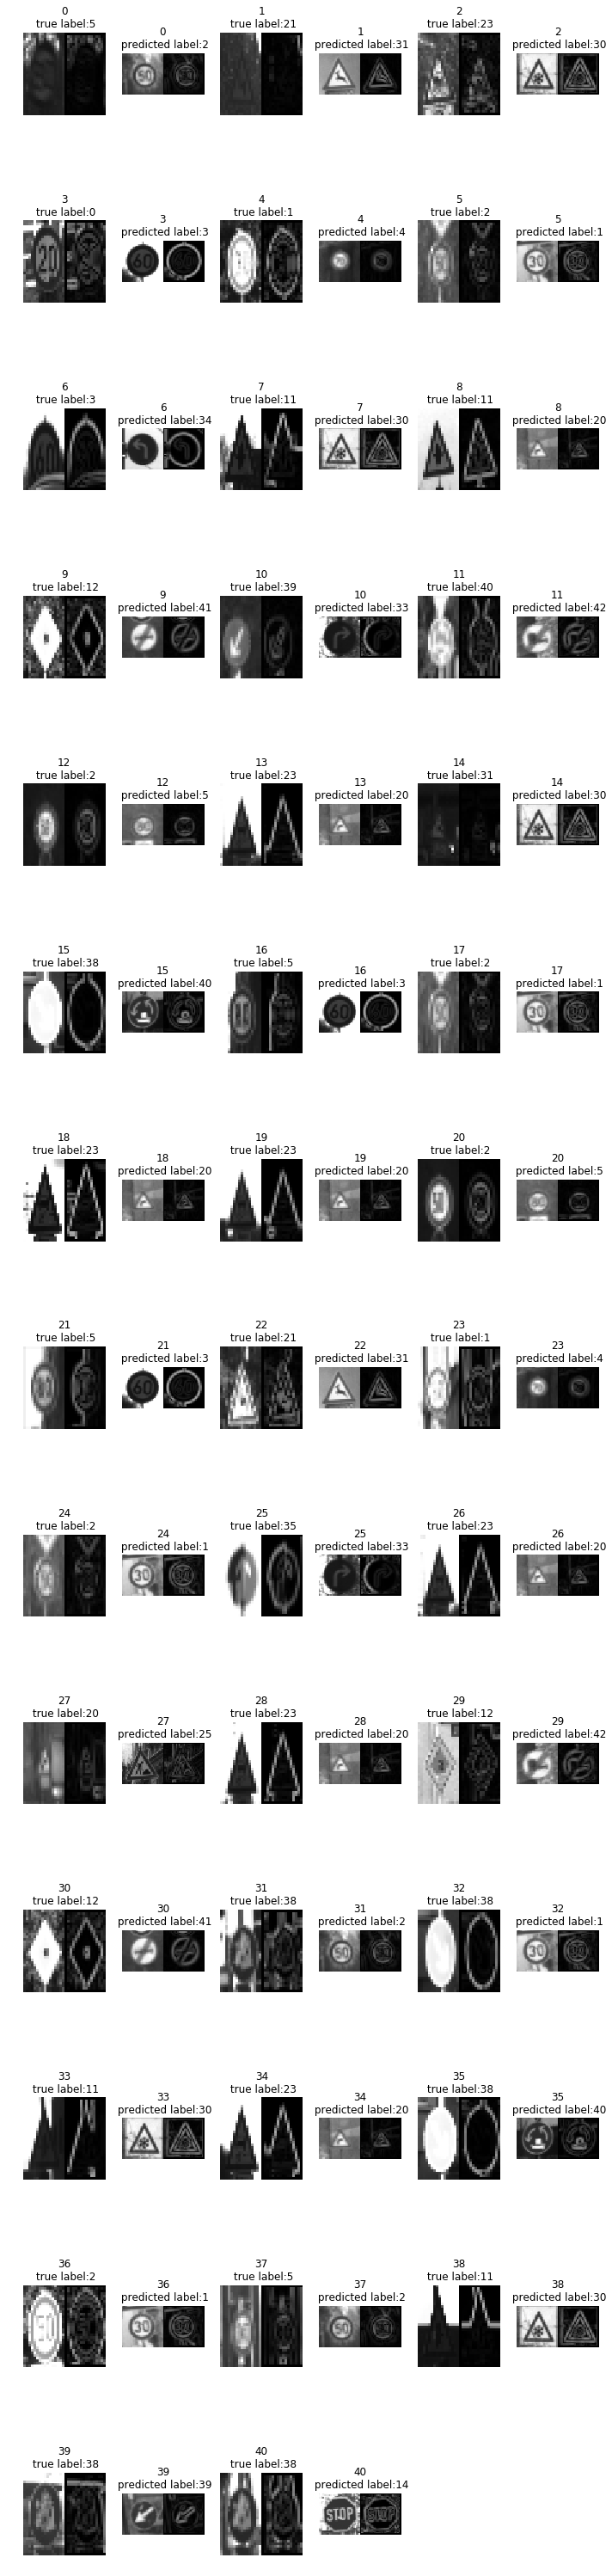

In [24]:
# show false answers
incorrect = (pred_results==False)    # len(incorrect)=1000
images = x_batch[incorrect]          # len(images) = total number of false predicted e.g 41 (of 1000)
# remove back channel dimension
images = np.squeeze(images)
images = images[:,:,:,0]
false_predict = pred_cls[incorrect]  # len(false_predict) == len(images)

true_labels = true_cls[incorrect]    # len(true_labels)== len(false_predict)==len(images)

# true_list = labels_tr
assert len(images)==len(false_predict)
m = len(images)
plt.figure(figsize=(12,4*m))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
counter = 1

for i in range(m):
    # this is what model has been false predicted
    plt.subplot(m,6, counter)
    plt.imshow(images[i], cmap=plt.cm.gray)
    plt.title("{}\n true label:{}".format(i, true_labels[i]))
    plt.axis('off')
    
    # this is the real label
    plt.subplot(m,6,counter+1)
    plt.imshow(images_tr[labels_tr.index(false_predict[i])], cmap=plt.cm.gray)
    plt.title("{}\n predicted label:{}".format(i, false_predict[i]))
    plt.axis('off')
    counter +=2
plt.show()
